***Note:*** *It is important to keep in mind that only the left eye data is being used as input, and the performance metrics are based solely on the left eye's predictive capabilities for the given classification task. If additional input data is required or desired for a comprehensive evaluation, further modifications to the code may be needed.*

*Importing Libraries*

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import zipfile
import os
import re
import random
import time
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

*Setting up Kaggle and Downloading Diabetic Retinopathy Dataset*

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged

# Open the zip file
with zipfile.ZipFile("/content/diabetic-retinopathy-resized-arranged.zip", "r") as zip_ref:
    # Extract all contents of the zip file to the current working directory
    zip_ref.extractall()

100% 1.21G/1.21G [00:53<00:00, 28.5MB/s]
100% 1.21G/1.21G [00:53<00:00, 24.0MB/s]


*Classifier Trainer with Multiple ML Algorithms*

In [2]:
class ClassifierTrainer:

    def __init__(self, algorithm='decision_tree', **kwargs):
        self.algorithm = algorithm

        if algorithm == 'decision_tree':
            self.model = DecisionTreeClassifier()
        elif algorithm == 'random_forest':
            self.model = RandomForestClassifier()
        elif algorithm == 'logistic_regression':
            self.model = LogisticRegression()
        elif algorithm == 'ridge_regression':
            self.model = RidgeClassifier()
        elif algorithm == 'sgd':
            self.model = SGDClassifier()
        elif algorithm == 'svm':
            self.model = SVC()
        elif algorithm == 'linear_svm':
            self.model = LinearSVC()
        elif algorithm == 'knn':
            self.model = KNeighborsClassifier()
        elif algorithm == 'naive_bayes':
            self.model = GaussianNB()
        elif algorithm == 'mlp':
            self.model = MLPClassifier()
        elif algorithm == 'adaboost':
            self.model = AdaBoostClassifier()
        elif algorithm == 'gradient_boost':
            self.model = GradientBoostingClassifier()
        else:
            raise ValueError("Invalid algorithm specified")

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        mcc = matthews_corrcoef(y_test, y_pred)
        conf = confusion_matrix(y_test, y_pred)
        return {
          'Algo': self.algorithm,
          'accuracy': accuracy,
          'precision': precision,
          'recall': recall,
          'f1': f1,
          'mcc': mcc,
          'conf': conf
        }

*List of Standard Machine Learning Models and Count*

In [25]:
standModels = ['decision_tree',
               'random_forest',
               'sgd',
               'svm',
               'knn',
               'naive_bayes',
               'mlp',]
len(standModels)

7

*Eye Image Data Preprocessing Function*

In [3]:
def import_eyes_images(df, Eye):
    images_eye = []
    labels = []
    for index, row in df.iterrows():
        eye_path = row[Eye+'Eye']
        label = float(row['class'])

        # Load and resize eye eye image
        eye = cv2.imread(eye_path)
        eye = cv2.resize(eye, (224, 224))

        # Append eye and right eye images to images list
        images_eye.append(eye)

        # Append label to labels list
        labels.append(label)

    # Convert lists to numpy arrays
    images_eye = np.array(images_eye)
    labels = np.array(labels)

    return images_eye, labels

*Data Splitting and Image Normalization for Eye Input*

In [4]:
def split_and_norm(eye_input, y):
    # Split data into training and testing sets
    eye_input_train, eye_input_test, y_train, y_test = train_test_split(eye_input, y, test_size=0.2, random_state=42)

    # Normalize pixel values of images
    eye_input_train = eye_input_train / 255.0
    eye_input_test = eye_input_test / 255.0

    return (
        eye_input_train,
        eye_input_test,
        y_train,
        y_test
    )

*Data Import and Left Eye Image Preprocessing*

In [5]:
df = pd.read_csv("balancedData.csv")
left_eye_input, y = import_eyes_images(df, 'left')
left_eye_input.shape

(1710, 224, 224, 3)

In [6]:
left_input_train, left_input_test, y_train, y_test = split_and_norm(left_eye_input, y)

In [7]:
left_input_test.shape, y_test.shape

((342, 224, 224, 3), (342,))

*Multi-Algorithm Training and Evaluation for Image Classification*

In [26]:
def train_list_models(list_model, X_train, Y_train, X_test, Y_test):
  accuracy = {}
  f1 = {}
  mcc = {}
  for algo in list_model:
    print(f"start: {algo}")
    start = time.time()
    testModel = ClassifierTrainer(algo)
    #train model
    X = X_train.reshape(X_train.shape[0], -1)
    testModel.train(X, Y_train)
    end = time.time()
    #test model
    Xs = X_test.reshape(X_test.shape[0], -1)
    model_eval = testModel.evaluate(Xs, Y_test)
    accuracy[algo] = model_eval['accuracy']
    f1[algo] = model_eval['f1']
    mcc[algo] = model_eval['mcc']
    model_eval["T_time"] = end - start
    print(algo+" algo has trained")
  return accuracy, f1, mcc

In [27]:
accuracy, f1, mcc = train_list_models(standModels, left_input_train, y_train, left_input_test, y_test)

start: decision_tree
decision_tree algo has trained
start: random_forest
random_forest algo has trained
start: sgd
sgd algo has trained
start: svm
svm algo has trained
start: knn
knn algo has trained
start: naive_bayes
naive_bayes algo has trained
start: mlp
mlp algo has trained


*Accuracy Comparison of Traditional Algorithms*

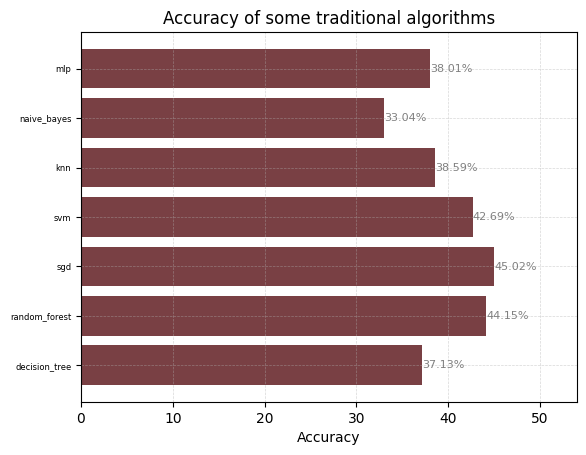

In [33]:
data = [x * 100 for x in accuracy.values()]
algo = list(accuracy.keys())
color = "#794044"

fig, ax = plt.subplots()
bars = ax.barh(np.arange(len(algo)), data, color=color)

for i, bar in enumerate(bars):

    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(data[i])[:5] + '%',
            ha='left', va='center', color='gray', fontsize=8)

ax.set_yticks(np.arange(len(algo)))  # Set y-ticks at each index position
ax.set_yticklabels(algo, fontsize=6)  # Set y-tick labels as algorithm names
ax.set_xlabel('Accuracy')
ax.set_title('Accuracy of some traditional algorithms')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Add space on the right side of the chart
plt.xlim(right=max(data) * 1.2)  # Adjust the multiplier as desired

plt.savefig('Accuracy_of_some_traditional_algorithms.png', transparent=True)
plt.show()

*Confusion Matrix Evaluation for Multiple Classifier Algorithms*

In [8]:
def get_conf_matrix(list_model, X_train, Y_train, X_test, Y_test):
  conf = {}
  for algo in list_model:
    print(f"start: {algo}")
    start = time.time()
    testModel = ClassifierTrainer(algo)
    #train model
    X = X_train.reshape(X_train.shape[0], -1)
    testModel.train(X, Y_train)
    end = time.time()
    #test model
    Xs = X_test.reshape(X_test.shape[0], -1)
    model_eval = testModel.evaluate(Xs, Y_test)
    conf[algo] = model_eval['conf']
    model_eval["T_time"] = end - start
    print(algo+" algo has trained")
  return conf

list_model = ['svm', 'random_forest', 'knn']
conf = get_conf_matrix(list_model, left_input_train, y_train, left_input_test, y_test)

start: svm
svm algo has trained
start: random_forest
random_forest algo has trained
start: knn
knn algo has trained


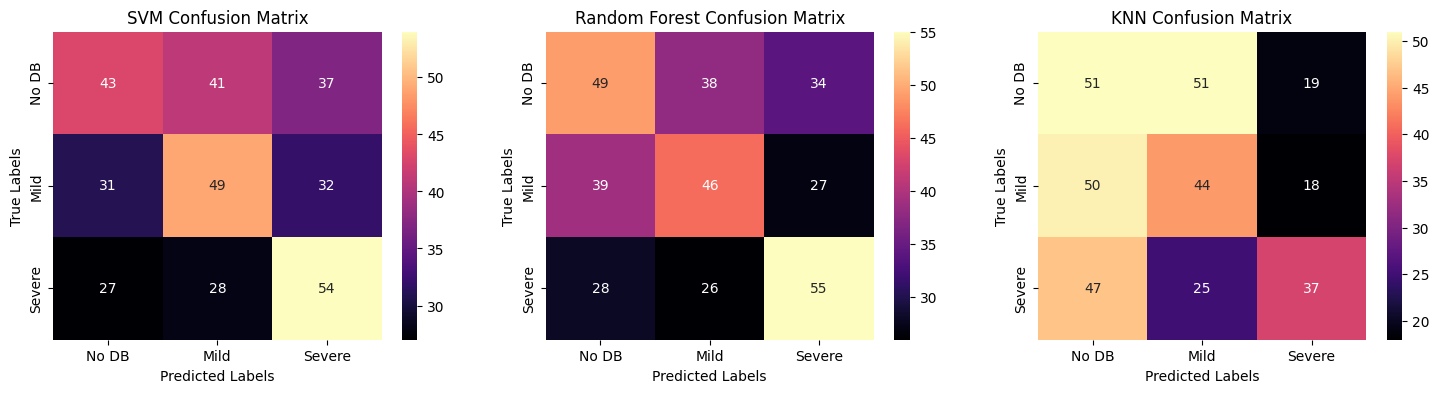

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(confusion_matrix, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

# Define the labels for the classes
class_labels = ['No DB', 'Mild', 'Severe']

# Assuming you have the confusion matrices stored in a dictionary called 'conf'
# where keys are the algorithm names ('svm', 'random_forest', 'knn') and values are the confusion matrices

# Create subplots for the three confusion matrices in one line
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot confusion matrix for algorithm 1
sns.heatmap(conf['svm'], annot=True, fmt="d", cmap="magma", xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")
axes[0].set_title("SVM Confusion Matrix")

# Plot confusion matrix for algorithm 2
sns.heatmap(conf['random_forest'], annot=True, fmt="d", cmap="magma", xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")
axes[1].set_title("Random Forest Confusion Matrix")

# Plot confusion matrix for algorithm 3
sns.heatmap(conf['knn'], annot=True, fmt="d", cmap="magma", xticklabels=class_labels, yticklabels=class_labels, ax=axes[2])
axes[2].set_xlabel("Predicted Labels")
axes[2].set_ylabel("True Labels")
axes[2].set_title("KNN Confusion Matrix")

plt.savefig('Confusion_Matrix_traditional_algorithms.png', transparent=True)
plt.show()